<div style="line-height:0.5">
<h1 style="color:#FF7C00  "> Radial Basis Network in TensorFlow 1 </h1>
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3> sys.maxsize + tf reduce_sum() + tf expand_dims()
    
</span>
</div> 

In [27]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  #to ignore CUDA warnings when GPU is not in use

In [28]:
import sys
sys.maxsize 

9223372036854775807

<h3 style="color:#FF7C00"> Recap: </h3>
<div style="margin-top: -8px;">

'sys.maxsize' is platform-dependent and its value is determined by the maximum size of a C size_t data type on the platform. <br>
On most platforms, sys.maxsize is 2^31-1 on a 32-bit system and 2^63-1 on a 64-bit system.    <br> 
'Maxsize' is a constant that represents the largest positive integer that can be used as an index for a sequence or array.  <br>
It is used to check the maximum size of a list, tuple or any other iterable on the current platform. <br>
</div>

In [51]:
import numpy
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

<h3 style="color:#FF7C00"> Note: </h3>
<div style="margin-top: -8px;">

The issue regarding the increment of the number associated with the Dense layer at each iteration <br> (even after clearing all outputs), is caused by the fact that the model architecture is being redefined multiple times in your Jupyter notebook.   <br>
After running the cell that defines the model, it adds a new instance of the model to the TensorFlow graph.   <br>
Therefore, running the cell multiple times, it will add multiple instances of the model to the graph, <br> each with a new number associated with the Dense layer. <br>    

To avoid this problem, it is necessary to clear the TensorFlow graph by restarting the kernel or using tf.keras.backend.clear_session() <br>before defining the model. <br>

</div>

In [30]:
""" Clear the TensorFlow graph """
tf.keras.backend.clear_session()

In [31]:
df_wine = pd.read_csv("./datasets/wine-red.csv")
df_wine[:10]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [32]:
df_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [33]:
""" Create a new instance of the MinMaxScaler class. """
# Create MinMaxScaler object to scale the data to a range between 0 and 1
minmaxScaler = MinMaxScaler()
df2 = df_wine.copy()

# Scale the 'volatile acidity' column of the dataset to a range between 0 and 1 using the MinMaxScaler
df2['volatile acidity'] = minmaxScaler.fit_transform(df2[['volatile acidity']])
# Scale the 'density' column of the dataset to a range between 0 and 1 using the MinMaxScaler
df2['density'] = minmaxScaler.fit_transform(df2[['density']])
# Scale the 'quality' column of the dataset to a range between 0 and 1 using the MinMaxScaler
df2['quality'] = minmaxScaler.fit_transform(df2[['quality']])

In [34]:
df2[:10]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.397260,0.00,1.9,0.076,11.0,34.0,0.567548,3.51,0.56,9.4,0.4
1,7.8,0.520548,0.00,2.6,0.098,25.0,67.0,0.494126,3.20,0.68,9.8,0.4
2,7.8,0.438356,0.04,2.3,0.092,15.0,54.0,0.508811,3.26,0.65,9.8,0.4
3,11.2,0.109589,0.56,1.9,0.075,17.0,60.0,0.582232,3.16,0.58,9.8,0.6
4,7.4,0.397260,0.00,1.9,0.076,11.0,34.0,0.567548,3.51,0.56,9.4,0.4
5,7.4,0.369863,0.00,1.8,0.075,13.0,40.0,0.567548,3.51,0.56,9.4,0.4
6,7.9,0.328767,0.06,1.6,0.069,15.0,59.0,0.464758,3.30,0.46,9.4,0.4
7,7.3,0.363014,0.00,1.2,0.065,15.0,21.0,0.332599,3.39,0.47,10.0,0.8
8,7.8,0.315068,0.02,2.0,0.073,9.0,18.0,0.494126,3.36,0.57,9.5,0.8
9,7.5,0.260274,0.36,6.1,0.071,17.0,102.0,0.567548,3.35,0.80,10.5,0.4


In [35]:
# Training
X_train = df2.iloc[:-199,[1, 7]]
Y_train = df2.iloc[:-199,-1]
# Validation
x = df2.iloc[-199:,[1,7]]
y = df2.iloc[-199:,-1]

In [36]:
# Normalize the input features using the StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X_train)

<h3 style="color:#FF7C00"> Recap: </h3>
<div style="margin-top: -8px;">


The Sequential model is one possible way to implement an RBF network in TensorFlow.<br>
The architecture of an RBF network typically consists of three layers: <br>
--> an input layer  <br>
--> a hidden layer of radial basis functions  <br>
--> an output layer  <br>

The hidden layer computes the distance between the input features and a set of learned centers, and applies radial basis functions <br> to these distances to produce the hidden layer activations.
</div>

In [37]:
#### Define a simple RBF network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1]),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

# Compile the model with the mean squared error loss function and the Adam optimizer
model.compile(loss='mse', optimizer='adam')

# Train the model on the training set for 100 epochs
history = model.fit(X_train, Y_train, epochs=100, validation_data=(x, y))

Epoch 1/100


44/44 [==============================] - 1s 6ms/step - loss: 0.3131 - val_loss: 0.1638
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 0.1158 - val_loss: 0.0546
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0374
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0358 - val_loss: 0.0342
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0329 - val_loss: 0.0317
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0296
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0286 - val_loss: 0.0280
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0268
Epoch 9/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0258 - val_loss: 0.0260
Epoch 10/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0252
Epoch 11/100
44/44 [=

In [38]:
# Evaluate the performance of the model on the testing set
score = model.evaluate(x, y)
print("Test loss:", score)

7/7 [==============================] - 0s 2ms/step - loss: 0.0221


Test loss: 0.022061271592974663


<h2 style="color:#FF7C00  "> Create RBFLayer </h2>

In [43]:
class RBFLayer(tf.keras.layers.Layer):
    """ Keras layer implementing a Radial Basis Function (RBF) hidden layer.\\
    The RBFLayer takes as input a tensor of shape (batch_size, input_dim) and outputs a tensor of shape (batch_size, output_dim).

    Args:
        - output_dim: Number of RBF units in the layer [int]
        - initializer: Initializer for RBF centers [str/callable, optional, Defaults to None]    
        - betas: Scaling factor for the RBFs to initialize the beta parameter with [float, optional, Defaults to 1.0]
            

    Attributes:
        - output_dim: Number of RBF units in the layer [int]
        - initializer: Initializer for RBF centers [str/callable, optional, Defaults to None]    
        - betas: Scaling factor for the RBFs to initialize the beta parameter with [float, optional, Defaults to 1.0]

    Methods:
        build(input_shape): Builds the RBF layer and adds trainable weights.
        call(inputs): Computes the output of the RBF layer based on the RBF activation.
    """    
    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.initializer = initializer
        self.betas = betas
        # Call the superclass constructor
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        """ Build two trainable variables and add trainable weights.\\
            - centers, which represents the centers of the rbf
            - betas, which represents the scaling factors for the rbf

        Parameters:
            - Shape of the input data
        """
        self.centers = self.add_weight(name='centers',
                                        shape=(self.output_dim, input_shape[1]),
                                        initializer=self.initializer,
                                        trainable=True)
        self.betas = self.add_weight(name='betas',
                                    shape=(self.output_dim,),
                                    initializer=tf.keras.initializers.Constant(value=self.betas),
                                    trainable=True)
        # Call the superclass build method
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        """ Compute the output of the RBF layer based on the RBF activation,\\
            which is the distance between the input features and the centers of the rbf.\\
            Apply the radial basis functions to these distances to produce the hidden layer activations,\\
            using Euclidean distance as the distance metric, and the Gaussian function as the radial basis function.\\
        
        Parameters:
            - Tensor with inputs

        Details: 
            - 1)
                - Add an additional dimension to 'inputs' for broadcasting with 'tf.expand_dims(inputs, axis=1)'\\
                to reshape 'inputs' from (batch_size, input_dim) to (batch_size, 1, input_dim)
                - Subtract 'self.centers' from each input sample to get a tensor of shape (batch_size, output_dim, input_dim)
                - Square the differences to get squared distances
                - Sum over the 'input_dim' dimension, 'axis=2' to the squared L2 distance between each input sample and each center
                            

            - 2) Compute the RBF activation values for the computed distances
                - Multiply each distance by the corresponding beta value (scaling factor) and negate it.
                - Apply the exponential function to these values, to get activation values as a Gaussian RBF

        Returns:
            Tensor containing the RBF activations for the input data.\\
            These activations represent the "response" of the RBF units to the input data.\\
                => The Exponential of the negative L2 distances
        """        
        dists = tf.sqrt(tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.centers), axis=2))
        res = tf.exp(-self.betas * dists)
        return res

In [40]:
""" Define the RBF network architecture with an RBFLayer with 10 output units. 
=> 3 layers!
N.B.
A common error that happens is that the RBFLayer is not passed correctly to the Dense Layer.
The latter expects a two-dimensional input tensor of shape (batch_size, num_units), 
but the output of the RBFLayer is a one-dimensional tensor of shape (batch_size, num_rbf_units).
Solution:
    It is necessary to add a Flatten layer after the RBFLayer to reshape the output tensor to a two-dimensional shape. 
""";
# wrong 1
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=X_train.shape[1]),
#     RBFLayer(output_dim=10),
#     tf.keras.layers.Dense(units=10),
#     tf.keras.layers.Dense(units=1)
# ])
# wrong 2
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(X_train.shape[1],)),
#     RBFLayer(output_dim=10),
#     tf.keras.layers.Dense(units=10, activation='relu'),
#     tf.keras.layers.Dense(units=1)
# ])

In [44]:
""" Create the new model. 
N.B. This lead to an error:
tf.keras.layers.Input(shape=X_train.shape[1])
"""
model = tf.keras.Sequential([
    RBFLayer(output_dim=10, input_shape=(X_train.shape[1],)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1)
])

# Compile the model with the mean squared error loss function and the Adam optimizer
model.compile(loss='mse', optimizer='adam')

In [45]:
""" Training """
history = model.fit(X_train, Y_train, epochs=100, validation_data=(x, y))
history

Epoch 1/100


44/44 [==============================] - 1s 8ms/step - loss: 0.2716 - val_loss: 0.1043
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0587 - val_loss: 0.0280
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0259 - val_loss: 0.0249
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0240 - val_loss: 0.0247
Epoch 5/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0238 - val_loss: 0.0245
Epoch 6/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0236 - val_loss: 0.0244
Epoch 7/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0235 - val_loss: 0.0242
Epoch 8/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0233 - val_loss: 0.0242
Epoch 9/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0233 - val_loss: 0.0242
Epoch 10/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0232 - val_loss: 0.0239
Epoch 11/100
44/44 [=

In [46]:
""" Evaluation """
loss = model.evaluate(x, y)
print("Test loss:", loss)

7/7 [==============================] - 0s 3ms/step - loss: 0.0228
Test loss: 0.02279110997915268


In [48]:
""" Predict """
y_pred = model.predict(x)
y_pred

7/7 [==============================] - 0s 3ms/step


array([[0.4803138 ],
       [0.4803138 ],
       [0.642075  ],
       [0.6358339 ],
       [0.5216126 ],
       [0.67718667],
       [0.63979965],
       [0.577929  ],
       [0.6771567 ],
       [0.577929  ],
       [0.47781223],
       [0.5643139 ],
       [0.63979965],
       [0.51705986],
       [0.5679354 ],
       [0.50520366],
       [0.5679354 ],
       [0.64981526],
       [0.56952316],
       [0.51130545],
       [0.56952316],
       [0.5926807 ],
       [0.54943746],
       [0.525911  ],
       [0.6321487 ],
       [0.6321487 ],
       [0.65123963],
       [0.60607237],
       [0.49185163],
       [0.7002534 ],
       [0.60840243],
       [0.5944622 ],
       [0.6218513 ],
       [0.6153475 ],
       [0.4523031 ],
       [0.4523031 ],
       [0.5539446 ],
       [0.45701852],
       [0.5168263 ],
       [0.5008224 ],
       [0.64698094],
       [0.45522016],
       [0.4782828 ],
       [0.58749163],
       [0.5008224 ],
       [0.45522016],
       [0.4782828 ],
       [0.468

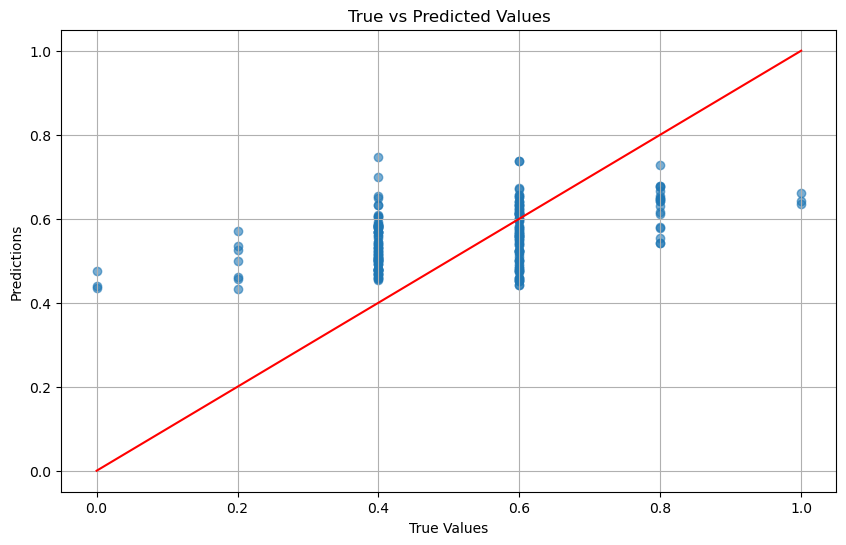

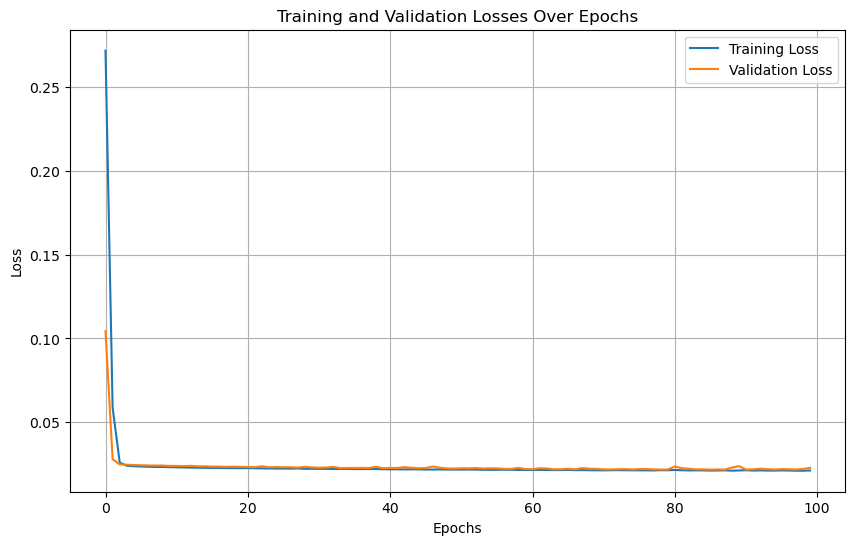

In [49]:
plt.figure(figsize=(10, 6))

# Scatter plot of true values vs predicted values
plt.scatter(y, y_pred, alpha=0.6)
# Plot the ideal prediction line
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')  
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
# Add grid
plt.grid(True)
plt.show()

# Additionally, you can plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()